# 여기서부터 시작 (21년01월07일)


### 1. 이미지 DataLoader 통해 불러오기

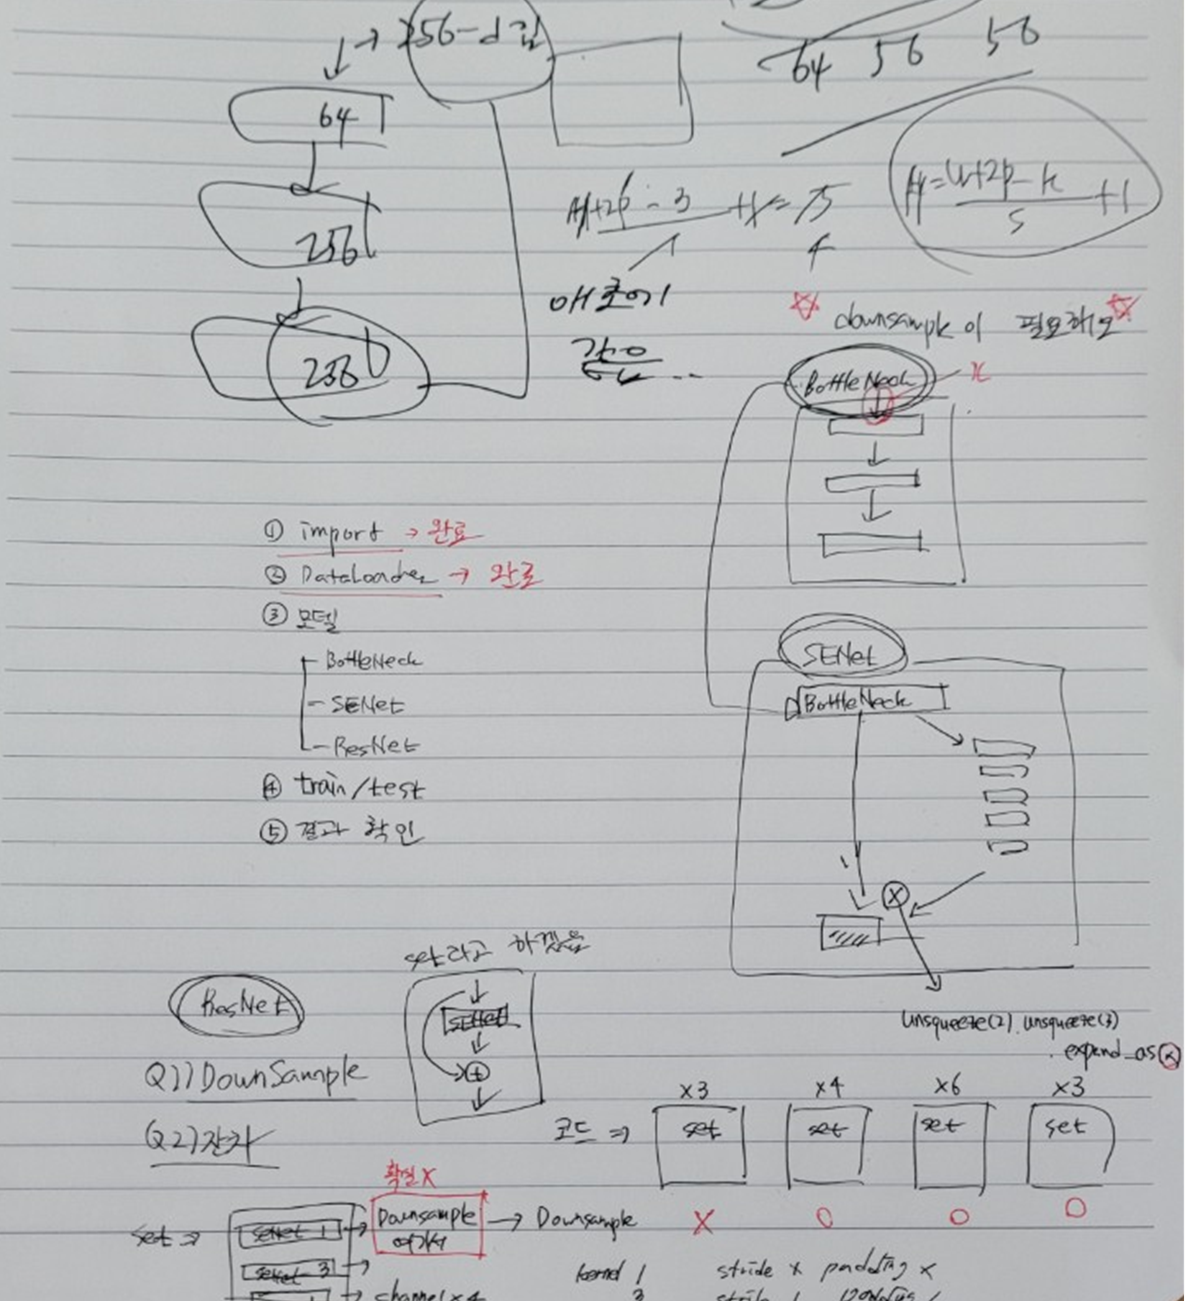

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# for reproducibility
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torchsummary import summary

In [ ]:
learning_rate = 0.6
momentum = 0.9
epochs = 100
batch_size = 1024

In [ ]:
def adjust_learning_rate(optimizer, epochs):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = 0.6 * (0.1 ** (epochs // 30))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [ ]:
def get_learning_rate(optimizer):
    lr = []
    for param_group in optimizer.param_groups:
        lr += [param_group['lr']]
    #print(param_group.head())
    return lr

In [ ]:


train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(
        root = "datasets/", 
        train = True, 
        download = True,
        

        transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.Resize(229),
            transforms.ToTensor(),
            transforms.Normalize(mean=[x / 255.0 for x in [125.3, 123.0, 113.9]], 
                                 std=[x / 255.0 for x in [63.0, 62.1, 66.7]])
        ])
        
    ),
    batch_size=batch_size, 
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(
        root = "datasets/", 
        train = False, # test 용도의 data 셋을 저장한다.
        download = True,
        transform = transforms.Compose([
            transforms.Resize(229),
            transforms.ToTensor(),
            transforms.Normalize(mean=[x / 255.0 for x in [125.3, 123.0, 113.9]], 
                                 std=[x / 255.0 for x in [63.0, 62.1, 66.7]])
        ])
    ),
    batch_size = batch_size,
    shuffle = True
)

Extracting datasets/cifar-10-python.tar.gz to datasets/
Files already downloaded and verified


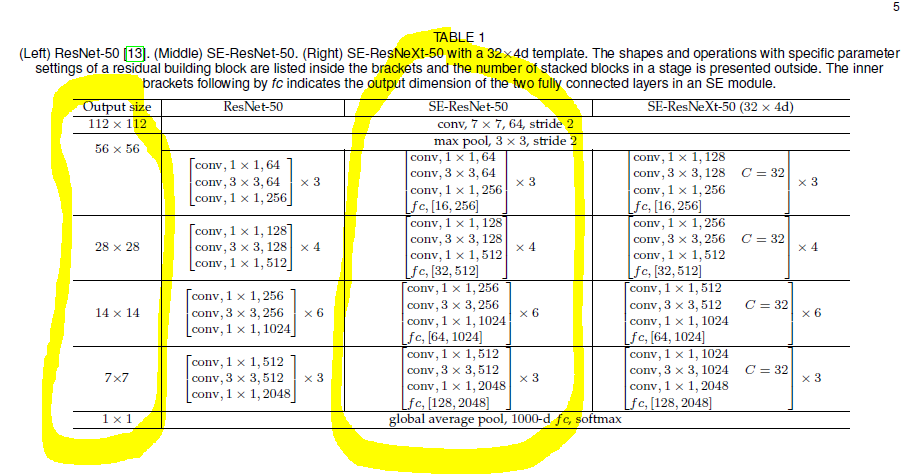

### 실험 1. SENet 안에 Bottleneck을 함수로 만들어 해보자

In [ ]:
class SENet(nn.Module):
  def __init__(self,inplanes,planes, downsample=None):
    super(SENet, self).__init__()
    self.conv77 = nn.Conv2d(3, inplanes ,kernel_size=7, stride=2, bias=False)
    self.maxpool = nn.AvgPool2d(kernel_size=3, stride=2)
    self.bottle = self.BottleNeck(inplanes, planes)
    self.GAP = nn.AdaptiveAvgPool2d((1,1))
    self.fc1 = nn.Linear(planes*4, int(planes*4/16),bias=False)
    self.fc2 = nn.Linear(int(planes*4/16), planes*4,bias=False)
    self.relu = nn.ReLU(inplace=True)
    self.sig = nn.Sigmoid()
  
  def forward(self, x):
    
    
    x = self.conv77(x)
    x = self.maxpool(x)
    res = x
    x = self.bottle(x)
    residual = x
    x = self.GAP(x)
    x = self.fc1(x.view(x.shape[0],-1))
    x = self.fc2(x)
    x = self.relu(x)
    x = self.sig(x)
    se = x.unsqueeze(2).unsqueeze(3).expand_as(residual)
    fin = residual*se
    res += fin
    return res


  def BottleNeck(self,inplanes, planes, downsample=None):
    # 첫 convolution에서 stride 가 2냐 default냐 차이
    if downsample is not None:
      return nn.Sequential(
        nn.Conv2d(inplanes,planes,kernel_size=1, stride = 2),
        nn.BatchNorm2d(planes),
        nn.ReLU(inplace=True),
        nn.Conv2d(planes, planes,kernel_size=3, padding=1,stride=1),
        nn.BatchNorm2d(planes),
        nn.ReLU(inplace=True),
        nn.Conv2d(planes, planes*4, kernel_size=1),
        nn.BatchNorm2d(planes*4),
        nn.ReLU(inplace=True)
    )
    else:
      return nn.Sequential(
        nn.Conv2d(inplanes,planes,kernel_size=1),
        nn.BatchNorm2d(planes),
        nn.ReLU(inplace=True),
        nn.Conv2d(planes, planes,kernel_size=3, padding=1,stride=1),
        nn.BatchNorm2d(planes),
        nn.ReLU(inplace=True),
        nn.Conv2d(planes, planes*4, kernel_size=1),
        nn.BatchNorm2d(planes*4),
        nn.ReLU(inplace=True)
        )

print('***SENet 구조***')
summary(SENet(1024,256),(3,229,229))
print('.\n.\n')

***SENet 구조***


RuntimeError: ignored

### 현재 구조는 ResNet-SENet을 한 번 밖에 적용 안한 것 
#### 3-4-6-3 해서 만들고
#### 마지가 linear 함수 적용도 해주어야

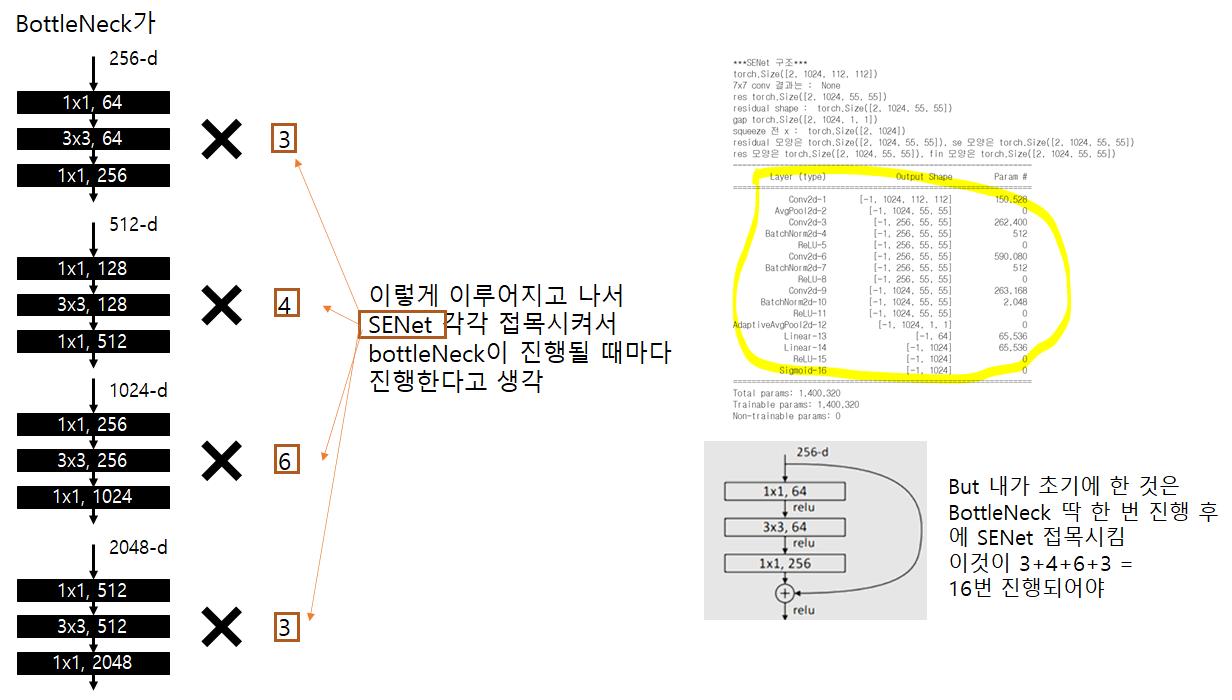

## 모델의 parameter가 3000만개가 넘어서 안의 resnet을 축소시키려고 하고 있습니다

In [ ]:
# 모델 너무 커서 이걸로
class ResNet(nn.Module):
  def __init__(self,inplanes):
    super(ResNet, self).__init__()
    self.conv77 = nn.Conv2d(3, inplanes ,kernel_size=7, stride=2, bias=False)
    self.maxpool = nn.AvgPool2d(kernel_size=3, stride=2)

    self.block1 = Res_block(256, 64, stride=1)

    self.fit1 = nn.Conv2d(256,512,1,bias = False)
    self.block2 = Res_block(512, 128, stride=1)
    self.down1 = nn.Conv2d(512, 512, 1,stride = 2, bias = False)

    self.avg = nn.AdaptiveAvgPool2d((1,1))
    self.linear = nn.Linear(512, 1000)

  def forward(self, x):
    x = self.conv77(x)
    x = self.maxpool(x)
    for _ in range(3):
      x = self.block1(x)
    x = self.fit1(x)
    for _ in range(4):
      x = self.block2(x)
    x = self.down1(x)

    x = self.avg(x)
    x = self.linear(x.view(x.shape[0],-1))

    return x

print('***ResNet 구조***')
model = ResNet(256)
summary(model,(3,229,229))
print('.\n.\n')



***ResNet 구조***
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 256, 112, 112]          37,632
         AvgPool2d-2          [-1, 256, 55, 55]               0
            Conv2d-3           [-1, 64, 55, 55]          16,384
       BatchNorm2d-4           [-1, 64, 55, 55]             128
              ReLU-5           [-1, 64, 55, 55]               0
            Conv2d-6           [-1, 64, 55, 55]          36,864
       BatchNorm2d-7           [-1, 64, 55, 55]             128
              ReLU-8           [-1, 64, 55, 55]               0
            Conv2d-9          [-1, 256, 55, 55]          16,384
      BatchNorm2d-10          [-1, 256, 55, 55]             512
             ReLU-11          [-1, 256, 55, 55]               0
AdaptiveAvgPool2d-12            [-1, 256, 1, 1]               0
           Linear-13                   [-1, 16]           4,096
           Linear-14   

## SE-ResNet 코드 구현입니다. 직접 다 했습니다!!!

In [ ]:
 class ResNet(nn.Module):
  def __init__(self):
    super(ResNet, self).__init__()
    self.conv77 = nn.Conv2d(3, 256 ,kernel_size=7, stride=2, bias=False)
    self.maxpool = nn.AvgPool2d(kernel_size=3, stride=2)

    self.blo  ck1 = Res_block(256, 64, stride=1).cuda()

    self.fit1 = nn.Conv2d(256,512,1,bias = False)
    self.block2 = Res_block(512, 128, stride=1).cuda()
    self.down1 = nn.Conv2d(512, 512, 1,stride = 2, bias = False)

    self.fit2 = nn.Conv2d(512, 1024,1,bias = False)
    self.block3 = Res_block(1024, 256, stride=1).cuda()
    self.down2 = nn.Conv2d(1024, 1024, 1,stride = 2, bias = False)

    self.fit3 = nn.Conv2d(1024, 2048,1,bias = False)
    self.block4 = Res_block(2048, 512, stride=1).cuda()
    self.down3 = nn.Conv2d(2048, 2048, 1,stride = 2, bias = False)

    self.avg = nn.AdaptiveAvgPool2d((1,1))
    self.linear = nn.Linear(2048, 1000)

  def forward(self, x):
    x = self.conv77(x)
    x = self.maxpool(x)
    for _ in range(3):
      x = self.block1(x)
    x = self.fit1(x)
    for _ in range(4):
      x = self.block2(x)
    x = self.down1(x)
    x = self.fit2(x)
    for _ in range(6):
      x = self.block3(x)
    x = self.down2(x) 
    x = self.fit3(x)
    for _ in range(3):
      x = self.block4(x)
    x = self.down3(x)
    x = self.avg(x)
    x = self.linear(x.view(x.shape[0],-1))

    return x

print('***ResNet 구조***')
model = ResNet(256).cuda()
summary(model,(3,229,229))
print('.\n.\n')



***ResNet 구조***


TypeError: ignored

In [ ]:
class SENet(nn.Module):
    def __init__(self,planes):
      super(SENet, self).__init__()
      self.GAP = nn.AdaptiveAvgPool2d((1,1))
      self.fc1 = nn.Linear(planes*4, int(planes*4/16),bias=False)
      self.fc2 = nn.Linear(int(planes*4/16), planes*4,bias=False)
      self.relu = nn.ReLU(inplace=True)
      self.sig = nn.Sigmoid()
  
    def forward(self, x):
      x = self.GAP(x)
      x = self.fc1(x.view(x.shape[0],-1)) # 
      # activation 함수 추가!
      x = self.fc2(x)
      x = self.relu(x) #수정
      x = self.sig(x)
      return x


In [ ]:
class Res_block(nn.Module):
  def __init__(self,inplanes,planes, stride = 1):
    super(Res_block, self).__init__()
    self.res = self.Residual(inplanes, planes, stride=1)
    self.senet = SENet(planes)
    
  def Residual(self,inplanes, planes, stride=1):
    return nn.Sequential(
        nn.Conv2d(inplanes,planes,kernel_size=1, stride = 1, bias=False),
        nn.BatchNorm2d(planes),
        nn.ReLU(inplace=True),
        nn.Conv2d(planes, planes,kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(planes),
        nn.ReLU(inplace=True),
        nn.Conv2d(planes, planes*4, kernel_size=1, bias=False),
        nn.BatchNorm2d(planes*4),
        nn.ReLU(inplace=True))

  def forward(self,x):
    res = x
    x = self.res(x)
    residual = x
    x = self.senet(x)
    se = x
    scale = residual*se.unsqueeze(2).unsqueeze(3).expand_as(residual)

    res += scale
    return res


In [ ]:
model = ResNet().cuda()

In [ ]:
model = torch.nn.DataParallel(model)

In [ ]:
import time

In [ ]:
criterion = torch.nn.CrossEntropyLoss().to(device)  # Softmax is internally computed.
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
total_batch = len(train_loader)
total_batch

49

In [ ]:
# train my model
total_batch = len(train_loader)
model.train()    # set the model to train mode (dropout=True)
print('Learning started. It takes sometime.')
for epoch in range(epochs):
    avg_cost = 0

    for X, Y in train_loader:
        # image is already size of (28x28), no reshape
        # label is not one-hot encoded
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

print('Learning Finished!')

Learning started. It takes sometime.


RuntimeError: ignored

In [ ]:
def train(model, train_loader, optimizer):

    model.train()
    end = time.time()
    current_LR = get_learning_rate(optimizer)[0]
    for batch_idx, (data, target) in enumerate(train_loader):


        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)

        loss.backward()

        optimizer.step()
        err1, err5 = accuracy(output.data, target, topk=(1, 5))
        batch_time.update(time.time() - end)
        end = time.time()

train(model, train_loader,optimizer)

